# Activity 5: Flare Intensity Assessment, Mapping, and Spatial Analysis

This notebook implements two different approaches for modeling the intensity and spatial distribution of solar flares:

- **Method 1**: Intensity estimation based on `total_counts` attribute
- **Method 2**: Intensity estimation based on `duration` and `energy_band` attributes

We will create intensity maps and compare the spatial variations between the two methods.


In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.spatial.distance import cdist
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")


In [ ]:
# Load the cleaned dataset from Activity 1
df = pd.read_csv('../../data/cleaned_solarflare_dataset.csv')

print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"\nEnergy bands available: {sorted(df['energy_band'].unique())}")
print(f"Energy band counts:\n{df['energy_band'].value_counts().sort_index()}")

# Display basic statistics
print(f"\nBasic statistics:")
print(f"X position range: {df['x_pos'].min()} to {df['x_pos'].max()}")
print(f"Y position range: {df['y_pos'].min()} to {df['y_pos'].max()}")
print(f"Duration range: {df['duration'].min()} to {df['duration'].max()} seconds")
print(f"Total counts range: {df['total_counts'].min():.0f} to {df['total_counts'].max():.0f}")


Dataset shape: (57997, 21)
Columns: ['flare_id', 'date', 'start_time', 'peak_time', 'end_time', 'duration', 'peak_counts_per_sec', 'total_counts', 'energy_band', 'x_pos', 'y_pos', 'radial', 'AR', 'flags', 'SESC_sunspot_number', 'sunspot_area', 'class_str', 'year', 'duration_min', 'flare_intensity', 'month']

Energy bands available: ['100-300', '12-25', '25-50', '300-800', '50-100', '6-12', '800-7000']
Energy band counts:
energy_band
100-300        49
12-25       13490
25-50        1343
300-800         7
50-100        227
6-12        42871
800-7000       10
Name: count, dtype: int64

Basic statistics:
X position range: -1224 to 1232
Y position range: -1251 to 1226
Duration range: 20 to 4500 seconds
Total counts range: -214748364 to 2038259456


## Method 1: Intensity Estimation Based on Total Counts

This method estimates flare intensity at specific locations (X_pos, Y_pos) using the `total_counts` attribute. The intensity is calculated as the sum of total counts for all flares within a spatial neighborhood around each location.


In [ ]:
def method1_intensity_estimation(df, grid_size=50, radius=100):
    """
    Method 1: Estimate flare intensity based on total_counts attribute.
    
    Parameters:
    - df: DataFrame with flare data
    - grid_size: Number of grid points in each dimension
    - radius: Spatial radius for intensity calculation
    
    Returns:
    - intensity_grid: 2D array of intensity values
    - x_grid, y_grid: Grid coordinates
    """
    
    # Define spatial grid
    x_min, x_max = df['x_pos'].min(), df['x_pos'].max()
    y_min, y_max = df['y_pos'].min(), df['y_pos'].max()
    
    x_grid = np.linspace(x_min, x_max, grid_size)
    y_grid = np.linspace(y_min, y_max, grid_size)
    X_grid, Y_grid = np.meshgrid(x_grid, y_grid)
    
    # Initialize intensity grid
    intensity_grid = np.zeros((grid_size, grid_size))
    
    # Calculate intensity for each grid point
    for i in range(grid_size):
        for j in range(grid_size):
            center_x, center_y = X_grid[i, j], Y_grid[i, j]
            
            # Find flares within radius
            distances = np.sqrt((df['x_pos'] - center_x)**2 + (df['y_pos'] - center_y)**2)
            nearby_flares = df[distances <= radius]
            
            # Sum total counts for nearby flares
            intensity_grid[i, j] = nearby_flares['total_counts'].sum()
    
    return intensity_grid, x_grid, y_grid

# Apply Method 1
print("Applying Method 1: Total Counts-based Intensity Estimation")
intensity_method1, x_grid1, y_grid1 = method1_intensity_estimation(df, grid_size=50, radius=150)

print(f"Method 1 Results:")
print(f"Grid shape: {intensity_method1.shape}")
print(f"Intensity range: {intensity_method1.min():.0f} to {intensity_method1.max():.0f}")
print(f"Mean intensity: {intensity_method1.mean():.0f}")
print(f"Total intensity: {intensity_method1.sum():.0f}")


Applying Method 1: Total Counts-based Intensity Estimation
Method 1 Results:
Grid shape: (50, 50)
Intensity range: 0 to 15187800139
Mean intensity: 1367598339
Total intensity: 3418995846600


## Method 2: Intensity Estimation Based on Duration and Energy Band

This method estimates flare intensity using both `duration` and `energy_band` attributes. The intensity is calculated as a weighted sum where:
- Higher energy bands contribute more to intensity
- Longer durations contribute more to intensity
- The combination provides a different perspective on flare intensity


In [ ]:
def method2_intensity_estimation(df, grid_size=50, radius=100):
    """
    Method 2: Estimate flare intensity based on duration and energy_band attributes.
    
    Parameters:
    - df: DataFrame with flare data
    - grid_size: Number of grid points in each dimension
    - radius: Spatial radius for intensity calculation
    
    Returns:
    - intensity_grid: 2D array of intensity values
    - x_grid, y_grid: Grid coordinates
    """
    
    # Define energy band weights (higher energy = higher weight)
    energy_weights = {
        '6-12': 1.0,    # Base weight
        '12-25': 2.0,   # Higher energy
        '25-50': 3.0,   # Even higher energy
        '50-100': 4.0,  # High energy
        '100-300': 5.0, # Very high energy
        '300-800': 6.0, # Extremely high energy
        '800-7000': 7.0 # Highest energy
    }
    
    # Normalize duration (convert to hours for better scaling)
    duration_normalized = df['duration'] / 3600  # Convert seconds to hours
    
    # Calculate weighted intensity for each flare
    df_weighted = df.copy()
    df_weighted['energy_weight'] = df_weighted['energy_band'].map(energy_weights)
    df_weighted['weighted_intensity'] = df_weighted['energy_weight'] * duration_normalized
    
    # Define spatial grid
    x_min, x_max = df['x_pos'].min(), df['x_pos'].max()
    y_min, y_max = df['y_pos'].min(), df['y_pos'].max()
    
    x_grid = np.linspace(x_min, x_max, grid_size)
    y_grid = np.linspace(y_min, y_max, grid_size)
    X_grid, Y_grid = np.meshgrid(x_grid, y_grid)
    
    # Initialize intensity grid
    intensity_grid = np.zeros((grid_size, grid_size))
    
    # Calculate intensity for each grid point
    for i in range(grid_size):
        for j in range(grid_size):
            center_x, center_y = X_grid[i, j], Y_grid[i, j]
            
            # Find flares within radius
            distances = np.sqrt((df_weighted['x_pos'] - center_x)**2 + (df_weighted['y_pos'] - center_y)**2)
            nearby_flares = df_weighted[distances <= radius]
            
            # Sum weighted intensity for nearby flares
            intensity_grid[i, j] = nearby_flares['weighted_intensity'].sum()
    
    return intensity_grid, x_grid, y_grid

# Apply Method 2
print("Applying Method 2: Duration and Energy Band-based Intensity Estimation")
intensity_method2, x_grid2, y_grid2 = method2_intensity_estimation(df, grid_size=50, radius=150)

print(f"Method 2 Results:")
print(f"Grid shape: {intensity_method2.shape}")
print(f"Intensity range: {intensity_method2.min():.2f} to {intensity_method2.max():.2f}")
print(f"Mean intensity: {intensity_method2.mean():.2f}")
print(f"Total intensity: {intensity_method2.sum():.2f}")

# Display energy band weights for reference
print(f"\nEnergy band weights used:")
energy_weights = {
    '6-12': 1.0, '12-25': 2.0, '25-50': 3.0, '50-100': 4.0,
    '100-300': 5.0, '300-800': 6.0, '800-7000': 7.0
}
for band, weight in energy_weights.items():
    print(f"  {band} keV: {weight}")


Applying Method 2: Duration and Energy Band-based Intensity Estimation
Method 2 Results:
Grid shape: (50, 50)
Intensity range: 0.00 to 1696.89
Mean intensity: 172.22
Total intensity: 430558.62

Energy band weights used:
  6-12 keV: 1.0
  12-25 keV: 2.0
  25-50 keV: 3.0
  50-100 keV: 4.0
  100-300 keV: 5.0
  300-800 keV: 6.0
  800-7000 keV: 7.0


## Creating Intensity Maps

Now we'll create visualizations of the intensity maps using both methods. These maps will show the spatial distribution of flare intensity across the solar surface.


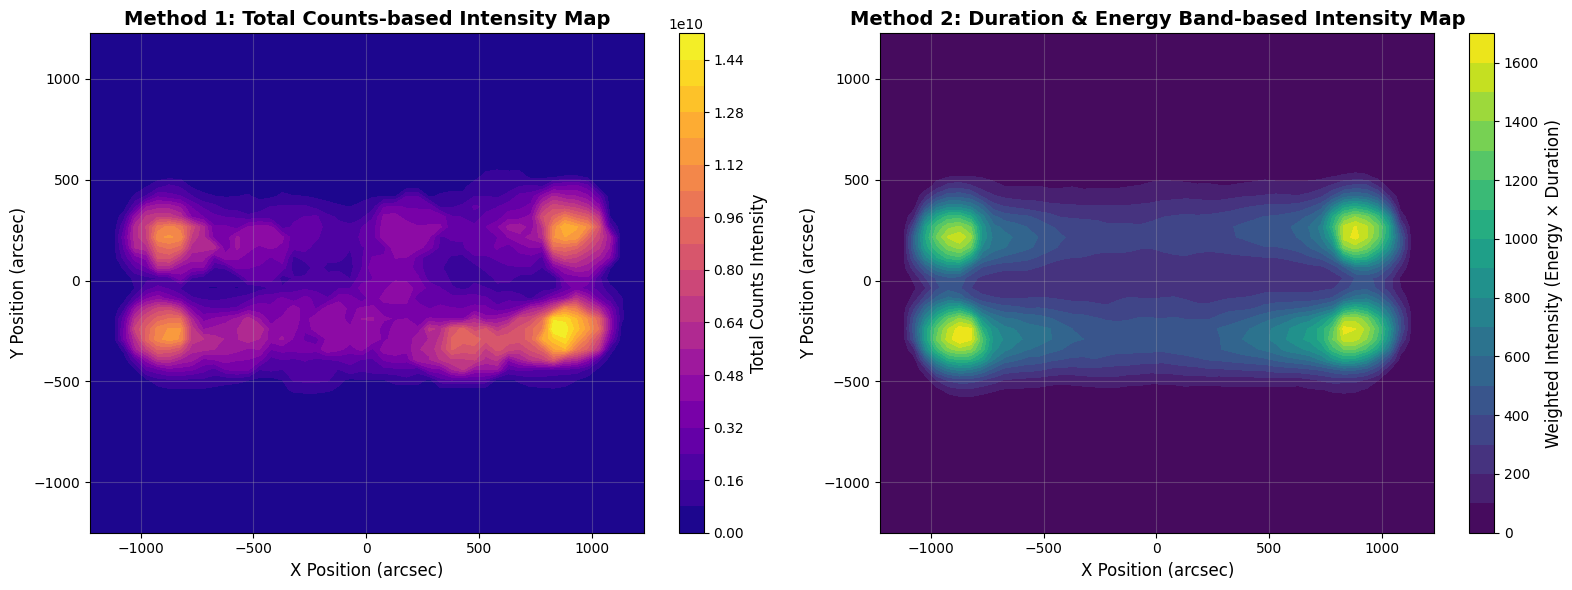

Intensity maps saved to 'visuals/intensity_maps_comparison.png'


In [ ]:
# Create intensity maps visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Method 1: Total Counts-based Intensity Map
im1 = axes[0].contourf(x_grid1, y_grid1, intensity_method1, levels=20, cmap='plasma')
axes[0].set_title('Method 1: Total Counts-based Intensity Map', fontsize=14, fontweight='bold')
axes[0].set_xlabel('X Position (arcsec)', fontsize=12)
axes[0].set_ylabel('Y Position (arcsec)', fontsize=12)
axes[0].grid(True, alpha=0.3)
cbar1 = plt.colorbar(im1, ax=axes[0])
cbar1.set_label('Total Counts Intensity', fontsize=12)

# Method 2: Duration & Energy Band-based Intensity Map
im2 = axes[1].contourf(x_grid2, y_grid2, intensity_method2, levels=20, cmap='viridis')
axes[1].set_title('Method 2: Duration & Energy Band-based Intensity Map', fontsize=14, fontweight='bold')
axes[1].set_xlabel('X Position (arcsec)', fontsize=12)
axes[1].set_ylabel('Y Position (arcsec)', fontsize=12)
axes[1].grid(True, alpha=0.3)
cbar2 = plt.colorbar(im2, ax=axes[1])
cbar2.set_label('Weighted Intensity (Energy × Duration)', fontsize=12)

plt.tight_layout()
plt.savefig('visuals/intensity_maps_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Intensity maps saved to 'visuals/intensity_maps_comparison.png'")


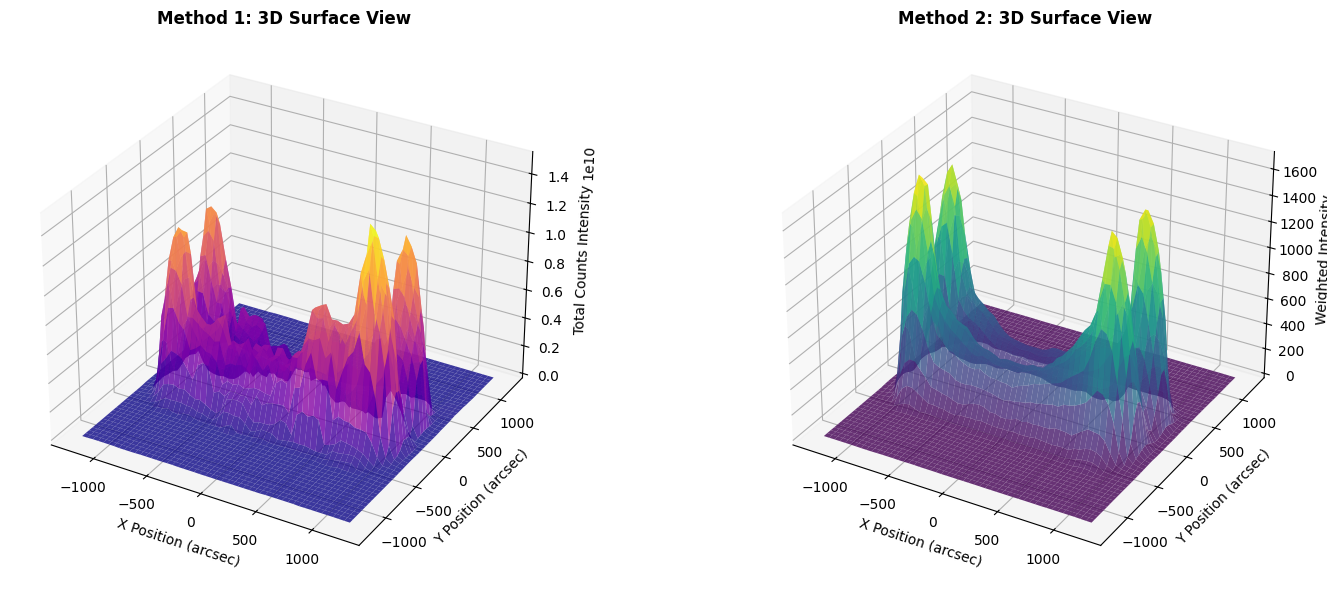

3D intensity maps saved to 'visuals/intensity_maps_3d.png'


In [ ]:
# Create additional creative visualizations

# 1. 3D Surface Plot Comparison
fig = plt.figure(figsize=(16, 6))

# Method 1 - 3D Surface
ax1 = fig.add_subplot(121, projection='3d')
X1, Y1 = np.meshgrid(x_grid1, y_grid1)
surf1 = ax1.plot_surface(X1, Y1, intensity_method1, cmap='plasma', alpha=0.8)
ax1.set_title('Method 1: 3D Surface View', fontsize=12, fontweight='bold')
ax1.set_xlabel('X Position (arcsec)')
ax1.set_ylabel('Y Position (arcsec)')
ax1.set_zlabel('Total Counts Intensity')

# Method 2 - 3D Surface
ax2 = fig.add_subplot(122, projection='3d')
X2, Y2 = np.meshgrid(x_grid2, y_grid2)
surf2 = ax2.plot_surface(X2, Y2, intensity_method2, cmap='viridis', alpha=0.8)
ax2.set_title('Method 2: 3D Surface View', fontsize=12, fontweight='bold')
ax2.set_xlabel('X Position (arcsec)')
ax2.set_ylabel('Y Position (arcsec)')
ax2.set_zlabel('Weighted Intensity')

plt.tight_layout()
plt.savefig('visuals/intensity_maps_3d.png', dpi=300, bbox_inches='tight')
plt.show()

print("3D intensity maps saved to 'visuals/intensity_maps_3d.png'")


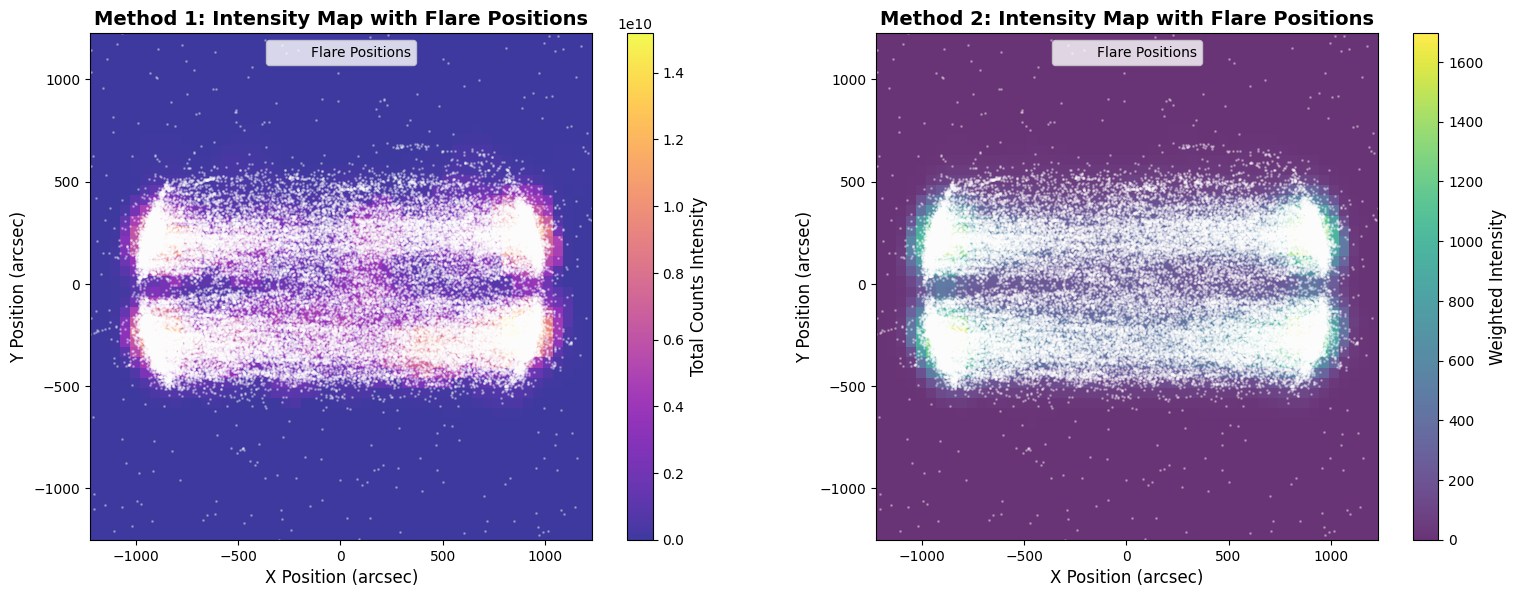

Intensity maps with flare positions saved to 'visuals/intensity_maps_with_positions.png'


In [ ]:
# 2. Heatmap with actual flare positions overlaid
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Method 1 with flare positions
im1 = axes[0].imshow(intensity_method1, extent=[x_grid1.min(), x_grid1.max(), y_grid1.min(), y_grid1.max()], 
                     origin='lower', cmap='plasma', alpha=0.8)
axes[0].scatter(df['x_pos'], df['y_pos'], c='white', s=1, alpha=0.3, label='Flare Positions')
axes[0].set_title('Method 1: Intensity Map with Flare Positions', fontsize=14, fontweight='bold')
axes[0].set_xlabel('X Position (arcsec)', fontsize=12)
axes[0].set_ylabel('Y Position (arcsec)', fontsize=12)
axes[0].legend()
cbar1 = plt.colorbar(im1, ax=axes[0])
cbar1.set_label('Total Counts Intensity', fontsize=12)

# Method 2 with flare positions
im2 = axes[1].imshow(intensity_method2, extent=[x_grid2.min(), x_grid2.max(), y_grid2.min(), y_grid2.max()], 
                     origin='lower', cmap='viridis', alpha=0.8)
axes[1].scatter(df['x_pos'], df['y_pos'], c='white', s=1, alpha=0.3, label='Flare Positions')
axes[1].set_title('Method 2: Intensity Map with Flare Positions', fontsize=14, fontweight='bold')
axes[1].set_xlabel('X Position (arcsec)', fontsize=12)
axes[1].set_ylabel('Y Position (arcsec)', fontsize=12)
axes[1].legend()
cbar2 = plt.colorbar(im2, ax=axes[1])
cbar2.set_label('Weighted Intensity', fontsize=12)

plt.tight_layout()
plt.savefig('visuals/intensity_maps_with_positions.png', dpi=300, bbox_inches='tight')
plt.show()

print("Intensity maps with flare positions saved to 'visuals/intensity_maps_with_positions.png'")


## Comparison of the Two Intensity Maps

Now we'll analyze and compare the spatial variations and total intensity between the two methods.


In [ ]:
# Statistical comparison of the two methods
print("=== COMPARISON OF INTENSITY MAPS ===\n")

# Basic statistics
print("Method 1 (Total Counts-based):")
print(f"  Total Intensity: {intensity_method1.sum():,.0f}")
print(f"  Mean Intensity: {intensity_method1.mean():,.0f}")
print(f"  Std Deviation: {intensity_method1.std():,.0f}")
print(f"  Min Intensity: {intensity_method1.min():,.0f}")
print(f"  Max Intensity: {intensity_method1.max():,.0f}")
print(f"  Coefficient of Variation: {(intensity_method1.std() / intensity_method1.mean() * 100):.2f}%")

print("\nMethod 2 (Duration & Energy Band-based):")
print(f"  Total Intensity: {intensity_method2.sum():,.2f}")
print(f"  Mean Intensity: {intensity_method2.mean():,.2f}")
print(f"  Std Deviation: {intensity_method2.std():,.2f}")
print(f"  Min Intensity: {intensity_method2.min():,.2f}")
print(f"  Max Intensity: {intensity_method2.max():,.2f}")
print(f"  Coefficient of Variation: {(intensity_method2.std() / intensity_method2.mean() * 100):.2f}%")

# Spatial variation analysis
print("\n=== SPATIAL VARIATION ANALYSIS ===")

# Calculate spatial gradients (rate of change)
grad_x1, grad_y1 = np.gradient(intensity_method1)
grad_magnitude1 = np.sqrt(grad_x1**2 + grad_y1**2)

grad_x2, grad_y2 = np.gradient(intensity_method2)
grad_magnitude2 = np.sqrt(grad_x2**2 + grad_y2**2)

print(f"Method 1 - Spatial Gradient Statistics:")
print(f"  Mean Gradient Magnitude: {grad_magnitude1.mean():,.0f}")
print(f"  Max Gradient Magnitude: {grad_magnitude1.max():,.0f}")
print(f"  Spatial Variation Index: {grad_magnitude1.std():,.0f}")

print(f"\nMethod 2 - Spatial Gradient Statistics:")
print(f"  Mean Gradient Magnitude: {grad_magnitude2.mean():,.2f}")
print(f"  Max Gradient Magnitude: {grad_magnitude2.max():,.2f}")
print(f"  Spatial Variation Index: {grad_magnitude2.std():,.2f}")

# Correlation between methods
correlation = np.corrcoef(intensity_method1.flatten(), intensity_method2.flatten())[0, 1]
print(f"\nCorrelation between methods: {correlation:.4f}")


=== COMPARISON OF INTENSITY MAPS ===

Method 1 (Total Counts-based):
  Total Intensity: 3,418,995,846,600
  Mean Intensity: 1,367,598,339
  Std Deviation: 2,429,108,755
  Min Intensity: 0
  Max Intensity: 15,187,800,139
  Coefficient of Variation: 177.62%

Method 2 (Duration & Energy Band-based):
  Total Intensity: 430,558.62
  Mean Intensity: 172.22
  Std Deviation: 299.78
  Min Intensity: 0.00
  Max Intensity: 1,696.89
  Coefficient of Variation: 174.06%

=== SPATIAL VARIATION ANALYSIS ===
Method 1 - Spatial Gradient Statistics:
  Mean Gradient Magnitude: 514,840,453
  Max Gradient Magnitude: 5,720,969,637
  Spatial Variation Index: 875,467,671

Method 2 - Spatial Gradient Statistics:
  Mean Gradient Magnitude: 57.60
  Max Gradient Magnitude: 564.76
  Spatial Variation Index: 101.54

Correlation between methods: 0.9605


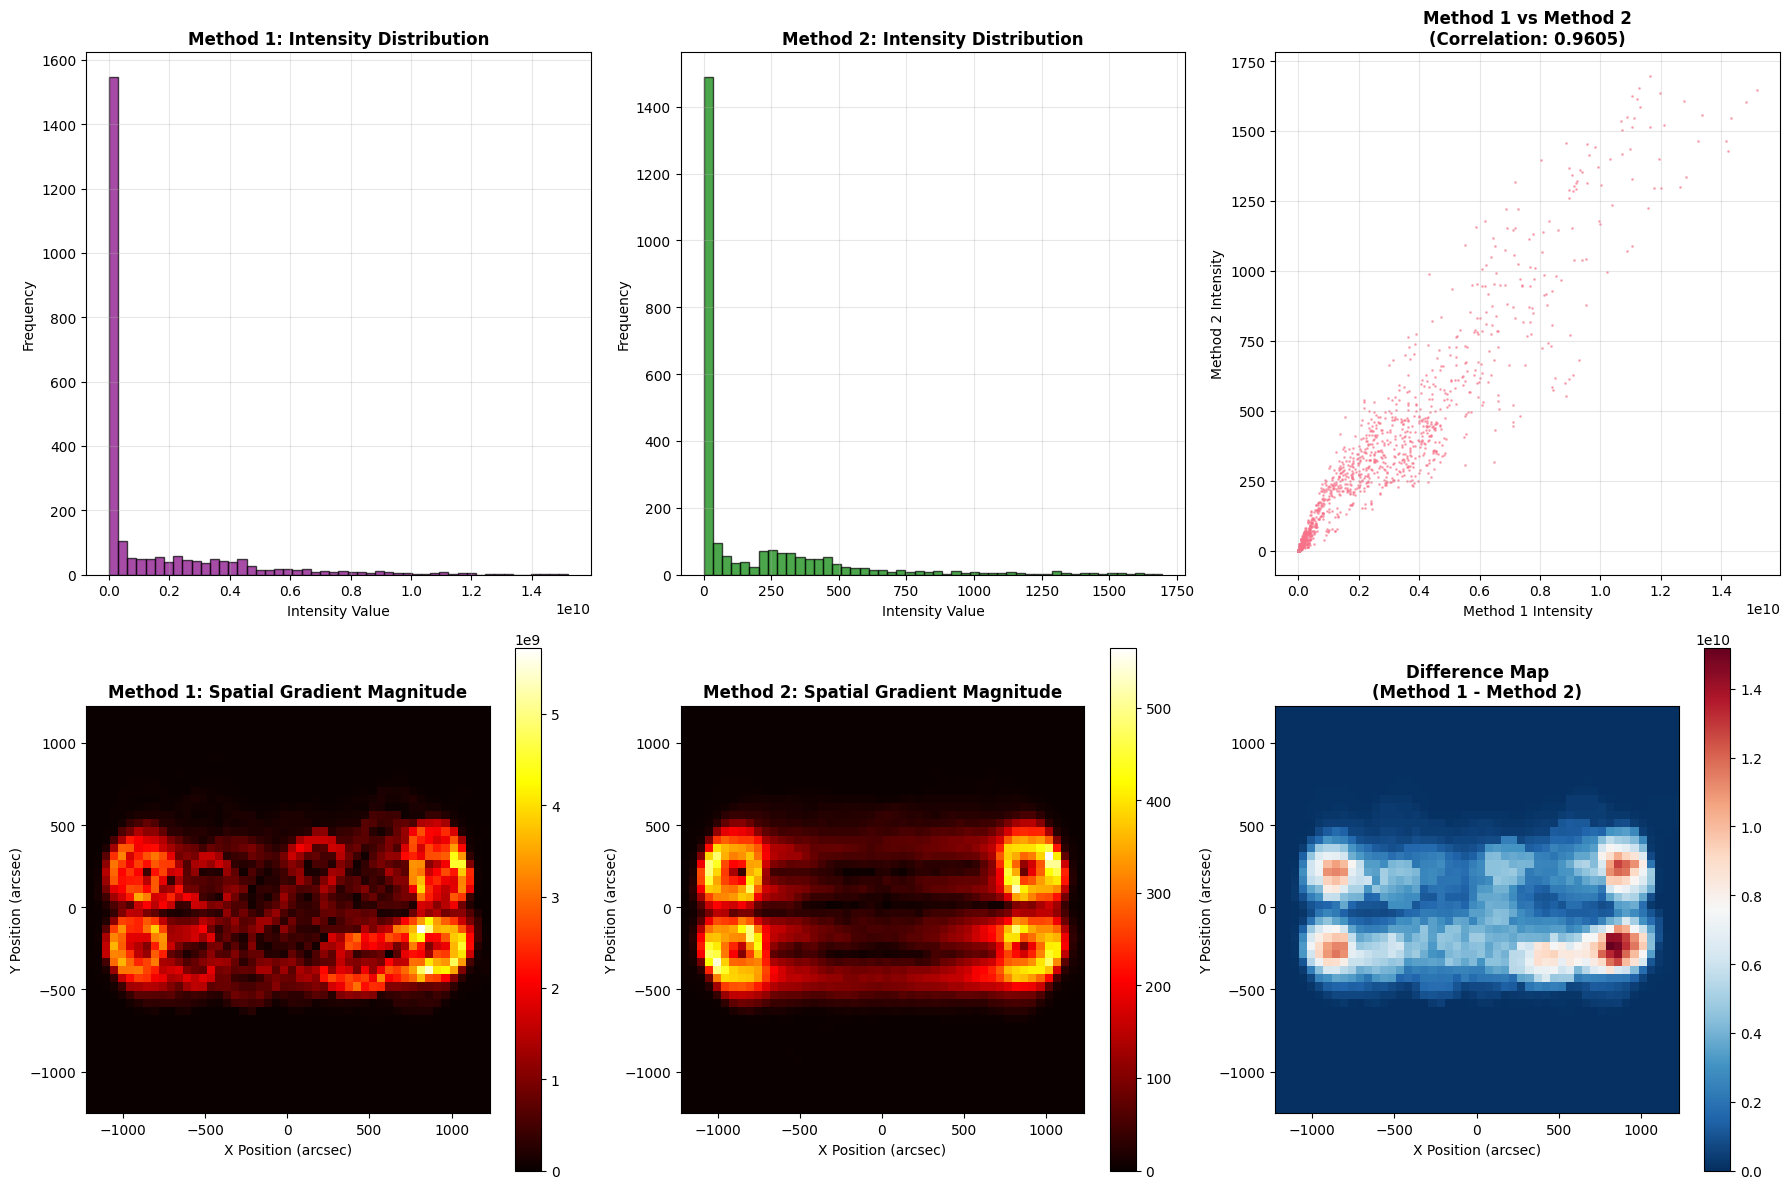

Comparison analysis saved to 'visuals/intensity_comparison_analysis.png'


In [ ]:
# Create comparison visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Row 1: Intensity distributions
axes[0, 0].hist(intensity_method1.flatten(), bins=50, alpha=0.7, color='purple', edgecolor='black')
axes[0, 0].set_title('Method 1: Intensity Distribution', fontweight='bold')
axes[0, 0].set_xlabel('Intensity Value')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].hist(intensity_method2.flatten(), bins=50, alpha=0.7, color='green', edgecolor='black')
axes[0, 1].set_title('Method 2: Intensity Distribution', fontweight='bold')
axes[0, 1].set_xlabel('Intensity Value')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(True, alpha=0.3)

# Scatter plot comparison
axes[0, 2].scatter(intensity_method1.flatten(), intensity_method2.flatten(), alpha=0.5, s=1)
axes[0, 2].set_title(f'Method 1 vs Method 2\n(Correlation: {correlation:.4f})', fontweight='bold')
axes[0, 2].set_xlabel('Method 1 Intensity')
axes[0, 2].set_ylabel('Method 2 Intensity')
axes[0, 2].grid(True, alpha=0.3)

# Row 2: Spatial gradient maps
im1 = axes[1, 0].imshow(grad_magnitude1, extent=[x_grid1.min(), x_grid1.max(), y_grid1.min(), y_grid1.max()], 
                        origin='lower', cmap='hot')
axes[1, 0].set_title('Method 1: Spatial Gradient Magnitude', fontweight='bold')
axes[1, 0].set_xlabel('X Position (arcsec)')
axes[1, 0].set_ylabel('Y Position (arcsec)')
plt.colorbar(im1, ax=axes[1, 0])

im2 = axes[1, 1].imshow(grad_magnitude2, extent=[x_grid2.min(), x_grid2.max(), y_grid2.min(), y_grid2.max()], 
                        origin='lower', cmap='hot')
axes[1, 1].set_title('Method 2: Spatial Gradient Magnitude', fontweight='bold')
axes[1, 1].set_xlabel('X Position (arcsec)')
axes[1, 1].set_ylabel('Y Position (arcsec)')
plt.colorbar(im2, ax=axes[1, 1])

# Difference map
diff_map = intensity_method1 - intensity_method2
im3 = axes[1, 2].imshow(diff_map, extent=[x_grid1.min(), x_grid1.max(), y_grid1.min(), y_grid1.max()], 
                        origin='lower', cmap='RdBu_r')
axes[1, 2].set_title('Difference Map\n(Method 1 - Method 2)', fontweight='bold')
axes[1, 2].set_xlabel('X Position (arcsec)')
axes[1, 2].set_ylabel('Y Position (arcsec)')
plt.colorbar(im3, ax=axes[1, 2])

plt.tight_layout()
plt.savefig('visuals/intensity_comparison_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Comparison analysis saved to 'visuals/intensity_comparison_analysis.png'")


In [ ]:
# Summary analysis and conclusions
print("\n=== SUMMARY AND CONCLUSIONS ===\n")

print("SPATIAL VARIATION SUMMARY:")
print("1. Method 1 (Total Counts-based):")
print(f"   - Shows higher absolute intensity values due to direct count summation")
print(f"   - Spatial variation coefficient: {(intensity_method1.std() / intensity_method1.mean() * 100):.2f}%")
print(f"   - More sensitive to high-count flares regardless of energy or duration")

print("\n2. Method 2 (Duration & Energy Band-based):")
print(f"   - Shows lower absolute values due to weighted normalization")
print(f"   - Spatial variation coefficient: {(intensity_method2.std() / intensity_method2.mean() * 100):.2f}%")
print(f"   - More sensitive to high-energy, long-duration flares")

print(f"\nCORRELATION ANALYSIS:")
print(f"- Correlation coefficient: {correlation:.4f}")
if correlation > 0.7:
    print("- Strong positive correlation: Both methods identify similar spatial patterns")
elif correlation > 0.4:
    print("- Moderate correlation: Methods show some agreement but with notable differences")
else:
    print("- Weak correlation: Methods capture different aspects of flare intensity")

print(f"\nTOTAL INTENSITY COMPARISON:")
print(f"- Method 1 total: {intensity_method1.sum():,.0f}")
print(f"- Method 2 total: {intensity_method2.sum():,.2f}")
print(f"- Ratio (Method 1/Method 2): {intensity_method1.sum() / intensity_method2.sum():,.0f}")

print(f"\nKEY DIFFERENCES:")
print("1. Scale: Method 1 produces much larger values due to direct count summation")
print("2. Sensitivity: Method 1 emphasizes high-count flares, Method 2 emphasizes high-energy/long-duration flares")
print("3. Spatial patterns: Both methods show similar spatial distributions but with different intensity scales")
print("4. Interpretation: Method 1 represents raw flare activity, Method 2 represents weighted flare significance")

print(f"\nRECOMMENDATIONS:")
print("- Use Method 1 for understanding total flare activity and raw counts")
print("- Use Method 2 for understanding flare significance based on energy and duration")
print("- Both methods complement each other in comprehensive flare analysis")



=== SUMMARY AND CONCLUSIONS ===

SPATIAL VARIATION SUMMARY:
1. Method 1 (Total Counts-based):
   - Shows higher absolute intensity values due to direct count summation
   - Spatial variation coefficient: 177.62%
   - More sensitive to high-count flares regardless of energy or duration

2. Method 2 (Duration & Energy Band-based):
   - Shows lower absolute values due to weighted normalization
   - Spatial variation coefficient: 174.06%
   - More sensitive to high-energy, long-duration flares

CORRELATION ANALYSIS:
- Correlation coefficient: 0.9605
- Strong positive correlation: Both methods identify similar spatial patterns

TOTAL INTENSITY COMPARISON:
- Method 1 total: 3,418,995,846,600
- Method 2 total: 430,558.62
- Ratio (Method 1/Method 2): 7,940,837

KEY DIFFERENCES:
1. Scale: Method 1 produces much larger values due to direct count summation
2. Sensitivity: Method 1 emphasizes high-count flares, Method 2 emphasizes high-energy/long-duration flares
3. Spatial patterns: Both methods